# Required Imports 


In [1]:
import pandas as pd
import random 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import math
import statistics
from statistics import mode
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics
from scipy.spatial import Voronoi
from dtw import dtw,accelerated_dtw
import operator
import warnings
warnings.filterwarnings("ignore")

# Data load

In [2]:
pressure_rest = pd.read_csv('pressure_rest.csv', header=None).to_numpy()
pressure_increment = pd.read_csv('pressure_increment.csv', header=None).to_numpy()
pressure_decrement = pd.read_csv('pressure_decrement.csv', header=None).to_numpy()

co2_rest = pd.read_csv('co2_rest.csv', header=None).to_numpy()
co2_increment = pd.read_csv('co2_increment.csv', header=None).to_numpy()
co2_decrement = pd.read_csv('co2_decrement.csv', header=None).to_numpy()

heartbeat_rest = pd.read_csv('heartbeat_rest.csv', header=None).to_numpy()
heartbeat_increment = pd.read_csv('heartbeat_increment.csv', header=None).to_numpy()
heartbeat_decrement = pd.read_csv('heartbeat_decrement.csv', header=None).to_numpy()


spo2_rest = pd.read_csv('spo2_rest.csv', header=None).to_numpy()
spo2_decrement = pd.read_csv('spo2_decrement.csv', header=None).to_numpy()


patients_data = pd.read_csv('patients_data.csv', header=None).to_numpy()

# Statistical values related to time series and other constants

Next we calculate some statistical estimators referring to the time series data, such as maximum, minimum values or standard deviations. 

In [3]:
MAX_PRESSURE = max(max([max(l) for l in pressure_rest]), max([max(l) for l in pressure_increment]), max([max(l) for l in pressure_decrement]))
MIN_PRESSURE = min(min([min(l) for l in pressure_rest]), min([min(l) for l in pressure_increment]), min([min(l) for l in pressure_decrement]))

print('PRESSURE:', MIN_PRESSURE, MAX_PRESSURE)

MAX_CO2 = max(max([max(l) for l in co2_rest]), max([max(l) for l in co2_increment]), max([max(l) for l in co2_decrement]))
MIN_CO2 = min(min([min(l) for l in co2_rest]), min([min(l) for l in co2_increment]), min([min(l) for l in co2_decrement]))

print('CO2:', MIN_CO2, MAX_CO2)


MAX_HEARTBEAT = max(max([max(l) for l in heartbeat_rest]), max([max(l) for l in heartbeat_increment]), max([max(l) for l in heartbeat_decrement]))
MIN_HEARTBEAT = min(min([min(l) for l in heartbeat_rest]), min([min(l) for l in heartbeat_increment]), min([min(l) for l in heartbeat_decrement]))

print('HEARTBEAT:', MIN_HEARTBEAT, MAX_HEARTBEAT)


MAX_SPO2 = max(max([max(l) for l in spo2_rest]),max([max(l) for l in spo2_decrement]))
MIN_SPO2 = min(min([min(l) for l in spo2_rest]),min([min(l) for l in spo2_decrement]))

print('SPO2:', MIN_SPO2, MAX_SPO2)


MAX_AGE = max([l[1] for l in patients_data])
MAX_HEIGHT = max([l[5] for l in patients_data])

MIN_AGE = min([l[1] for l in patients_data])
MIN_HEIGHT = min([l[5] for l in patients_data])

print('AGE:', MIN_AGE, MAX_AGE)
print('HEIGHT:', MIN_HEIGHT, MAX_HEIGHT)

STD_HEARTBEAT = np.std([max(l) for l in heartbeat_rest])
STD_SPO2 = np.std([max(l) for l in spo2_rest])
STD_AGE = np.std([l[1] for l in patients_data])
STD_HEIGHT = np.std([l[5] for l in patients_data])

print('STD_HEARTBEAT',STD_HEARTBEAT)
print('STD_SPO2',STD_SPO2)
print('STD_AGE',STD_AGE)
print('STD_HEIGHT',STD_HEIGHT)


PRESSURE: 100842.97463067314 101204.50894173824
CO2: 215.90192693892067 702.8438993197449
HEARTBEAT: 28.630582123908557 131.36941787609143
SPO2: 84.10845337987462 106.84831488320778
AGE: 15 65
HEIGHT: 140.47 190.86
STD_HEARTBEAT 7.027502596086906
STD_SPO2 1.7123317009178343
STD_AGE 14.622424526732905
STD_HEIGHT 7.5553567869158895


We also calculate some constants, such as the size of the case base

In [4]:
dseries_available = [pressure_rest, pressure_increment, co2_increment, co2_rest, heartbeat_rest, spo2_rest, patients_data]
NUM_PATIENTS_AVAILABLE = min(list(map(lambda l : len(l) ,dseries_available)))
print(NUM_PATIENTS_AVAILABLE)

5000


# Patient retrieval

We then define a function that receives a tuple of patient data and returns it normalized. Based on this function, we will later define a patient retrieval function from the generated time series data. 

In [5]:
def normalized_patient(patient_tuple):
  age = float(patient_tuple[1]) / float(MAX_AGE)
  sex = patient_tuple[2]
  smoker = patient_tuple[3]

  # Min-Max Normalized attributes:  
  height = (float(patient_tuple[5]) - float(MIN_HEIGHT)) / (float(MAX_HEIGHT) - float(MIN_HEIGHT))
  co2 = [(float(v) - float(MIN_CO2))/(float(MAX_CO2)-MIN_CO2) for v in patient_tuple[9]]
  ppm = [(float(v) - float(MIN_HEARTBEAT))/(float(MAX_HEARTBEAT)-MIN_HEARTBEAT) for v in patient_tuple[10]]
  pressure = [(float(v) - float(MIN_PRESSURE))/(float(MAX_PRESSURE)-MIN_PRESSURE) for v in patient_tuple[11]]
  spo2 = [(float(v) - float(MIN_SPO2))/(float(MAX_SPO2)-MIN_SPO2) for v in patient_tuple[12]]
  
  return (age, sex, smoker, height, co2, ppm, pressure, spo2)

Now we define patient types

In [6]:
PATIENT_TYPES = ["ok", "hr_inc", "hr_dec", "spo2_dec", "co2_inc", "co2_dec", "mip_inc", "mip_dec"]

Function to create noise time series

In [7]:
def createNoise(list, percentage, noiseType):
  if percentage==0: 
    return list
  if noiseType=='none':
    return list
  errorIndexes = random.sample(range(1,len(list)-1), (int)(len(list-1)*percentage/100))
  errorIndexes.sort()
  copyList = list.copy()
  for i in errorIndexes:
    if noiseType=='missing':
      copyList[i]=copyList[i-1]
    if noiseType=='error':
      copyList[i] = random.random()
  return copyList

The next function returns on the one hand the list of patient attributes and also the type of anomaly detected.

In [8]:
def retrieve_patient_normalized(patient_id, patient_type, noisePercentage, noiseType):
  co2 = co2_increment[patient_id] if patient_type=="co2_inc" else co2_decrement[patient_id] if patient_type=="co2_dec" else co2_rest[patient_id]
  heartbeat = heartbeat_increment[patient_id] if patient_type=="hr_inc" else heartbeat_decrement[patient_id] if patient_type=="hr_dec" else heartbeat_rest[patient_id]
  pressure = pressure_increment[patient_id] if patient_type=="mip_inc" else pressure_decrement[patient_id] if patient_type=="mip_dec" else pressure_rest[patient_id]
  spo2 = spo2_decrement[patient_id] if patient_type=="spo2_dec" else spo2_rest[patient_id]
  
  co2 = createNoise(co2, noisePercentage, noiseType)
  heartbeat = createNoise(heartbeat, noisePercentage, noiseType)
  pressure = createNoise(pressure, noisePercentage, noiseType)
  spo2 = createNoise(spo2, noisePercentage, noiseType)


  patients_data[patient_id][2] = 0 if patients_data[patient_id][2] == ' hombre' else 1
  patients_data[patient_id][3] = 0 if patients_data[patient_id][3] == ' no fumador' else 1
  result = normalized_patient(list(tuple(patients_data[patient_id]) + (co2, heartbeat, pressure, spo2))), patient_type
  return result

# CBR Experimentation class

In [1]:
class CaseBaseExperimentation:
  """ 
  A simple Case Base class built for experimentation.
  """

  def __euclideanSimilarity(self, lhs, rhs):
    if (isinstance(lhs, list) or isinstance(lhs, (np.ndarray, np.generic))) and (isinstance(rhs, list) or isinstance(rhs, (np.ndarray, np.generic))):
      return math.sqrt(sum([abs(x-y)**2 for x,y in zip(lhs, rhs)]))
    elif (isinstance(lhs, int) or isinstance(lhs, float)) and (isinstance(rhs, int) or isinstance(rhs, float)):
      return abs(lhs-rhs)
    elif isinstance(lhs, str) and isinstance(rhs, str):
      return int(lhs!=rhs)

  def __pearsonSimilarity(self, lhs, rhs):
    if (isinstance(lhs, list) or isinstance(lhs, (np.ndarray, np.generic))) and (isinstance(rhs, list) or isinstance(rhs, (np.ndarray, np.generic))):
      return -np.corrcoef(lhs, rhs)[0][1]
    elif (isinstance(lhs, int) or isinstance(lhs, float)) and (isinstance(rhs, int) or isinstance(rhs, float)):
      return abs(lhs-rhs)
    elif isinstance(lhs, str) and isinstance(rhs, str):
      return int(lhs!=rhs)

  def __dtwSimilarity(self, lhs, rhs):
    if (isinstance(lhs, list) or isinstance(lhs, (np.ndarray, np.generic))) and (isinstance(rhs, list) or isinstance(rhs, (np.ndarray, np.generic))):
      d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(np.array(lhs), np.array(rhs), 'euclidean')
      return d 
    elif (isinstance(lhs, int) or isinstance(lhs, float)) and (isinstance(rhs, int) or isinstance(rhs, float)):
      return abs(lhs-rhs)
    elif isinstance(lhs, str) and isinstance(rhs, str):
      return int(lhs!=rhs)

  def __slopeSimilarity(self, lhs, rhs):
    if (isinstance(lhs, list) or isinstance(lhs, (np.ndarray, np.generic))) and (isinstance(rhs, list) or isinstance(rhs, (np.ndarray, np.generic))):
      x_seq = np.arange(len(lhs)) #[ 0  1  2  3  4 ... 26]
      slope1, intercept1 = np.polyfit(x_seq,lhs,1)
      slope2, intercept2 = np.polyfit(x_seq,rhs,1)        
      return abs(slope1-slope2) 
    elif (isinstance(lhs, int) or isinstance(lhs, float)) and (isinstance(rhs, int) or isinstance(rhs, float)):
      return abs(lhs-rhs)
    elif isinstance(lhs, str) and isinstance(rhs, str):
      return int(lhs!=rhs)

  def __init__(self):
    self.casebase = []
    self.weights = []
    self.types = []
    self.similarities = { "euclidean" : self.__euclideanSimilarity,
                          "pearson": self.__pearsonSimilarity,
                          "dtw": self.__dtwSimilarity,
                          "slope": self.__slopeSimilarity
                        }

  def retrieveMostSimilar(self, newCase, similarity='euclidean'):
    bestScore = math.inf
    bestScoreIndex = -1
    similarityFunction = self.similarities[similarity]
    for idx, case in enumerate(self.casebase):
      numerator = sum([w * similarityFunction(cj, ncj) for (w, cj, ncj) in zip(self.weights[idx], case, newCase)])
      denominator = sum(self.weights[idx])
      score = numerator/denominator
      if score < bestScore:
        bestScore = score
        bestScoreIndex = idx

    if bestScoreIndex == -1:
      return bestScore, [], -1
    else:
      return bestScore, self.casebase[bestScoreIndex], self.types[bestScoreIndex], bestScoreIndex  

  def retrieveKNN(self, newCase, k, similarity='euclidean'):
    bestScore = math.inf
    bestScoreIndex = -1
    similarityFunction = self.similarities[similarity]
    neighbours = []
    for idx, case in enumerate(self.casebase):
      numerator = sum([w * similarityFunction(cj, ncj) for (w, cj, ncj) in zip(self.weights[idx], case, newCase)])
      denominator = sum(self.weights[idx])
      score = numerator/denominator
      neighbours.append((score,idx,self.types[idx]))
    sortedList = sorted(neighbours, key=lambda tup: tup[0])
    return sortedList[:k]

  def simpleVotingAdaptation(self, neighbours):
    types = list(zip(*neighbours))[2]
    return mode(types)


  def addCase(self, c, t, w=None):
    self.casebase.append(c)
    self.weights.append([1 for _ in c] if w == None else w) # Default weight = 1
    self.types.append(t)

  def addCasesEqual(self, list_cases, list_types):
    for patient, patient_type in zip(list_cases, list_types):
      self.addCase(patient, patient_type)

# Evaluation functions

We first define the function that randomly generates a set of train and test patient identifiers given a given size for the train set:

In [10]:
def generateRandomTestTrainDatasets(test_size = math.ceil(NUM_PATIENTS_AVAILABLE*.25), train_size = math.ceil(NUM_PATIENTS_AVAILABLE*.75), seed=5): #  print("test size ", len(test_dataset))


  random.seed(seed)

  patient_ids = [(i, random.choice(PATIENT_TYPES)) for i in range(0, NUM_PATIENTS_AVAILABLE)]
  random.shuffle(patient_ids)
  train_dataset, test_dataset = train_test_split(patient_ids, train_size=train_size, test_size=test_size)
  return test_dataset, train_dataset

We then include an auxiliary function to know which method will be used to add new patients to the knowledge base depending on the desired strategy/methodology for the calculation of weights:

In [2]:
def methodApplied(methodology, patients_list, patients_types):
  return operator.methodcaller({
       "EW": 'addCasesEqual'
       }[methodology], patients_list, patients_types)

Following method computes cross-validation datasets

In [12]:
def prepareCasebaseExperiment(testSize, trainSize, methodology, noisePercent, noiseType):
  #print("preparing Case Base. wait. ")
  casebase = CaseBaseExperimentation()
  test_dataset, train_dataset = generateRandomTestTrainDatasets(testSize, trainSize)
  number_samples_train = len(train_dataset)
  patients_list = []
  patients_types = []
  for i in range(0, number_samples_train):
    p_anomaly, p_type = retrieve_patient_normalized(*train_dataset.pop(), noisePercent, noiseType)
    patients_list.append(p_anomaly)
    patients_types.append(p_type)
  weight_methodology = methodApplied(methodology, patients_list, patients_types)
  weight_methodology(casebase)
  #print("preparing Case Base. done. ")
  return casebase, test_dataset

Last we define the evaluation function that computes actual and predicted labels, and accuracy score

In [13]:
def testCasebase(casebase, test_dataset, similarity, noisePercent, noiseType, k):
  yPred = []
  yTrue = []
  number_test_samples = len(test_dataset)
  while len(test_dataset) > 0:
    patient, actualClass = retrieve_patient_normalized(*test_dataset.pop(), noisePercent, noiseType)
    #predClass = casebase.retrieveMostSimilar(p_anomaly, similarity)[2]
    nn = casebase.retrieveKNN(patient,k,similarity)
    predClass = casebase.simpleVotingAdaptation(nn)
    yPred.append(predClass)
    yTrue.append(actualClass)
  score = metrics.accuracy_score(yTrue, yPred)
  return score, yTrue, yPred

# Global evaluation

Following code executes evaluation according to several parameters

Score (accuracy) obtained:  0.886
Precision:  0.886
              precision    recall  f1-score   support

     co2_dec       0.88      0.92      0.90       114
     co2_inc       0.92      0.95      0.94       133
      hr_dec       0.93      0.86      0.89       118
      hr_inc       0.88      0.91      0.90       128
     mip_dec       0.94      0.94      0.94       125
     mip_inc       0.96      0.92      0.94       128
          ok       0.63      0.66      0.64       127
    spo2_dec       0.99      0.91      0.95       127

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



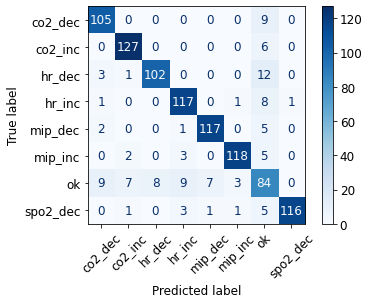

In [20]:
plt.rcParams.update({'font.size': 12})
test = 1000
train = 4000
noise = 0
noiseType = 'none'
k=3
casebase, test_dataset = prepareCasebaseExperiment(test, train, 'EW', noise, noiseType)
#print(len(test_dataset))
globalScore, yTrue, yPred = testCasebase(casebase, test_dataset, "euclidean", noise, noiseType, k)
cm = confusion_matrix(yTrue, yPred)
print("Score (accuracy) obtained: ", globalScore)
print("Precision: ",metrics.precision_score(yTrue, yPred, average='micro'))
#print(metrics.recall_score(yTrue, yPred, average='micro'))

labels = list(set(yTrue))
labels.sort()

print(classification_report(yTrue, yPred, target_names=labels))
labels = list(set(yTrue))
labels.sort()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap = 'Blues')
tick_marks = len(labels)
plt.xticks(rotation=45)
plt.show()

# Evaluation of k parameter

In [43]:
def testk(kvalues, test, train, noise, noiseType, similarity):
  scores = []
  for k in kvalues:
    print("Testing k: ",k)
    casebase, test_dataset = prepareCasebaseExperiment(test, train, 'EW', noise, noiseType)
    globalScore, yTrue, yPred = testCasebase(casebase, test_dataset, similarity, noise, noiseType, k)
    scores.append(globalScore)
  return scores

In [45]:
test = 500
train = 2000
noise = 0
noiseType = 'none'
kvalues = [1,3,5,10,25,50]
kscoresEuclidean = testk(kvalues, test, train, noise, noiseType, 'euclidean')
kscoresPearson = testk(kvalues, test, train, noise, noiseType, 'pearson')
kscoresSlope = testk(kvalues, test, train, noise, noiseType, 'slope')
print(kscoresEuclidean)

Testing k:  1
Testing k:  3
Testing k:  5
Testing k:  10
Testing k:  25
Testing k:  50
Testing k:  1
Testing k:  3
Testing k:  5
Testing k:  10
Testing k:  25
Testing k:  50
Testing k:  1
Testing k:  3
Testing k:  5
Testing k:  10
Testing k:  25
Testing k:  50
[0.856, 0.904, 0.88, 0.896, 0.904, 0.892]


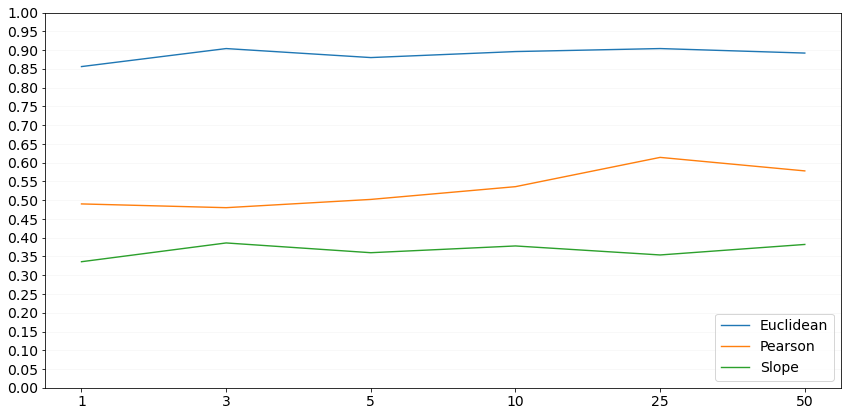

In [47]:
plt.rcParams.update({'font.size': 14})
lineplot = pd.DataFrame(list(zip(kscoresEuclidean, kscoresPearson, kscoresSlope)),
                        columns =['Euclidean', 'Pearson','Slope'])
plt.figure(figsize=(12,6), tight_layout=True)
plt.plot(lineplot, '-', linewidth=1.4)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xticks(lineplot.index, kvalues)
plt.grid(axis = 'y', alpha = 0.1)
plt.legend(loc='lower right', title_fontsize = 13, labels=['Euclidean', 'Pearson','Slope'])
plt.show()

# Cold-start evaluation

Following code simulates cold-start by evaluating with diferent case-base sizes

In [57]:
def runExperiment(lowerBound, upperBound, testPercent, methodology, similarity, noise, noiseType, k):
  print("Running experiment for methodology:", methodology,
        "number of patients in casebase will range from: ", lowerBound, " to: ", upperBound)
  scores = []
  stage1 = math.ceil((upperBound-lowerBound)* 0.25 + lowerBound)
  stage2 = math.ceil((upperBound-lowerBound)* 0.5 + lowerBound)
  stage3 = math.ceil((upperBound-lowerBound)* 0.75 + lowerBound)

  for i in range(lowerBound, upperBound+1):
    if i == stage1:
      print("25% of the experiment reached!")
    elif i == stage2: 
      print("50% of the experiment reached!")
    elif i == stage3:
      print("75% of the experiment reached!")
    testSize = math.ceil(max(1,i*testPercent))
    casebase, test_dataset = prepareCasebaseExperiment(testSize, i, methodology, noise, noiseType)
    (score, yTrue, yPred) = testCasebase(casebase, test_dataset, similarity, noise, noiseType, k)
    scores.append(score)
  return scores

In [58]:
minExp = 10
maxExp = 500
testSizeExp = .1
noise = 0
noiseType = 'none'
k=3

Run cold-start experiments according to parameters above

In [59]:
euclidean_scores = runExperiment(minExp,maxExp,testSizeExp,"EW","euclidean",noise, noiseType, k)

Running experiment for methodology: EW number of patients in casebase will range from:  10  to:  500
25% of the experiment reached!
50% of the experiment reached!
75% of the experiment reached!


In [60]:
pearson_scores = runExperiment(minExp,maxExp,testSizeExp, "EW","pearson", noise, noiseType, k)

Running experiment for methodology: EW number of patients in casebase will range from:  10  to:  500
25% of the experiment reached!
50% of the experiment reached!
75% of the experiment reached!


In [61]:
slope_scores = runExperiment(minExp,maxExp,testSizeExp, "EW","slope", noise, noiseType, k)

Running experiment for methodology: EW number of patients in casebase will range from:  10  to:  500
25% of the experiment reached!
50% of the experiment reached!
75% of the experiment reached!


plot cold-start

In [62]:
plt.rcParams.update({'font.size': 14})

In [63]:
lineplot = pd.DataFrame(list(zip(euclidean_scores, pearson_scores, slope_scores)),
                        columns =['Euclidean', 'Pearson','Slope'])

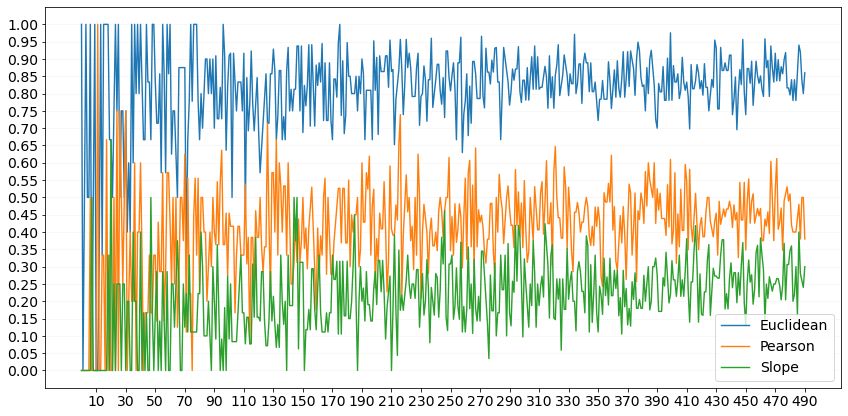

In [81]:
plt.figure(figsize=(12,6), tight_layout=True)
plt.plot(lineplot, '-', linewidth=1.4)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xticks(np.arange(10, 500, 20), np.arange(10, 500, 20))
plt.grid(axis = 'y', alpha = 0.1)
plt.legend(loc='lower right', title_fontsize = 13, labels=['Euclidean', 'Pearson','Slope'])
plt.show()

# Noise tolerance evaluation

In [82]:
noiseLevels = range(75,0,-5)

def evaluateNoise(testSize, trainSize, noiseType, k):
  scores = []
  for noiseLevel in noiseLevels:
    casebase, test_dataset = prepareCasebaseExperiment(testSize, trainSize, 'EW', noiseLevel, noiseType)
    score, yTrue, yPred = testCasebase(casebase, test_dataset, "euclidean", noiseLevel, noiseType, k)
    scores.append(score)
  return scores



In [83]:
test = 500
train = 4500
k =3
scoresMissing = evaluateNoise(test,train, 'missing',k)

In [84]:
scoresError = evaluateNoise(test,train, 'error',k)

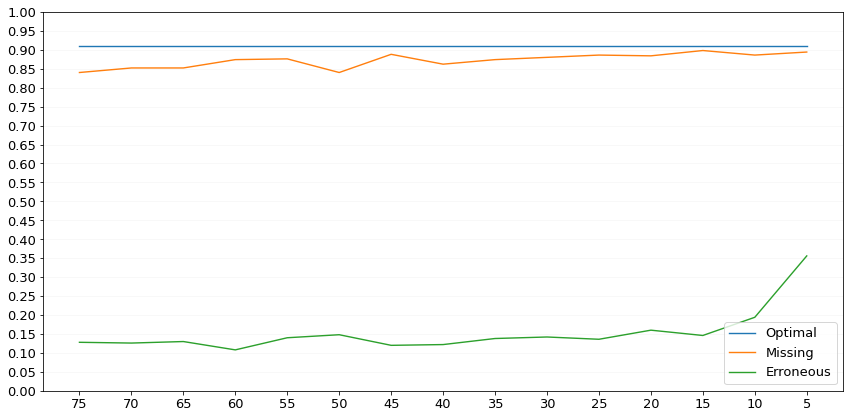

In [85]:
plt.rcParams.update({'font.size': 13})


baseline = [.91] * len(noiseLevels) 
lineplot = pd.DataFrame(list(zip(baseline, scoresMissing, scoresError)),
                        columns =['Optimal', 'Missing', 'Erroneous'])
plt.figure(figsize=(12,6), tight_layout=True)
plt.plot(lineplot, '-', linewidth=1.4)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xticks(lineplot.index, noiseLevels)
#ax = plt.gca()
#ax.set_xticklabels(range(75,0,-5))
plt.grid(axis = 'y', alpha = 0.1)
plt.legend(loc='lower right', title_fontsize = 13, labels=['Optimal', 'Missing', 'Erroneous'])
plt.show()